In [1]:
import pandas as pd
import numpy as np
import math

# For making plots and figures
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning library
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster

import time, random

from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)

from sklearn.preprocessing import MinMaxScaler

import ClusterEnsembles as CE
from sklearn.metrics import normalized_mutual_info_score

from sklearn.neighbors import NearestCentroid
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist

## Single Quality Selection (SQI)

In [2]:
# Set path for saving results to your local computer
dataset_path = '/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/CES Data/Project 3 IR+Raman Data/'
output_path = '/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/CES ML results/Project 3 IR+Raman Results/'

### II. Comparison of the selected subset using different quality index

#### Select J ensemble members, where J = (10, 210, 10) 
* Subset 0 [*_As reference set]: random sample J ensemble members from full ensemble with replacement
* Subset 1: highest Q1 ('SNMI')
* Subset 2: highest Q2 ('Silhouette')
* Subset 3: highest Q3 ('Calinski_Harabasz')
* Subset 4: highest Q4 ('Davies_Bauldin')

Functions for creating subset and nonsubset then calculate dominant ratio and NMI

In [3]:
def create_random_subset(J):
    df = df_result_merge.iloc[0:300]
    
    # Creating subset by randomly select J ensemble members from full ensemble with replacement
    set_idx = np.random.choice(Full_EN_Members,size=J,replace=True)
    subset=df.loc[set_idx]
    #print(subset.shape[0])
    
    # Save all non-selected ensemble members in another dataframe
    non_set = df.drop(set_idx,axis=0)
    #print(non_set.shape[0])
    
    return subset, non_set

In [4]:
def create_subset(J, df_rank_sorted):
    df = df_result_merge.iloc[0:300]
    
    set_idx = df_rank_sorted.iloc[0:J].index
    #print(set_idx)
    subset=df.loc[set_idx]
    #print(subset)
        
    non_set = df.drop(set_idx,axis=0)
    #print(non_set.shape[0])

    return subset, non_set

In [5]:
def Dominant_ratio(subset, non_subset, consensus_function):
    
    Y1 = CE.cluster_ensembles(subset.values, solver = consensus_function, verbose=False, nclass = 16, random_state=42)
    Y2 = CE.cluster_ensembles(non_subset.values, solver = consensus_function, verbose=False, nclass = 16, random_state=42)
    
    NMI1 = normalized_mutual_info_score(Y,Y1)
    NMI2 = normalized_mutual_info_score(Y,Y2)
    
    return NMI1, NMI1/NMI2

### Start here!!!

In [6]:
print("Change the filename for the dataset that you running analysis for!!!")
filename="0.971 scaled DFT 6-311++G(d,p) Raman dataset"
df_class = pd.read_csv(dataset_path+filename+".csv")
print("Y is the ground truth class label, to be used in calculation for the final performance evaluation")
Y=df_class.Class

Change the filename for the dataset that you running analysis for!!!
Y is the ground truth class label, to be used in calculation for the final performance evaluation


In [61]:
run_i="run_20"

print("Load the full ensemble: ")
print(output_path+filename+" BC library "+run_i+".csv")
print("from previous step")
df_result_merge = pd.read_csv(output_path+filename+" BC library "+run_i+".csv", index_col="Unnamed: 0")
print("Load the quality indices of full ensemble from previous step")
df_BC_quality_merge = pd.read_csv(output_path+filename+" BC library quality indices "+run_i+".csv", index_col="BC_run")

Y_HBGF_EN = df_result_merge.loc["HBGF_EN"]
Y_CSPA_EN = df_result_merge.loc["CSPA_EN"]
NMI_CSPA_EN = normalized_mutual_info_score(Y,Y_CSPA_EN)
print("NMI of CSPA consensus solution using full ensemble:", NMI_CSPA_EN)
NMI_HBGF_EN = normalized_mutual_info_score(Y,Y_HBGF_EN)
print("NMI of HBGF consensus solution using full ensemble:", NMI_HBGF_EN)
NMI_Average = df_BC_quality_merge['NMI_Y'].mean()
print("Average NMI of full ensemble:", NMI_Average)
Full_EN_Members = df_result_merge.index[0:300]

Load the full ensemble: 
/Users/hek/Research/Cheminformatics/Project_3_ML for Raman data/CES ML results/Project 3 IR+Raman Results/0.971 scaled DFT 6-311++G(d,p) Raman dataset BC library run_20.csv
from previous step
Load the quality indices of full ensemble from previous step
NMI of CSPA consensus solution using full ensemble: 0.6644367574016721
NMI of HBGF consensus solution using full ensemble: 0.7017198876883016
Average NMI of full ensemble: 0.5977420160131025


#### Create Subsets using different quality indices as well as bagging strategy
##### For J = (10, 210, 10):
* Create selected subset
* Compute consensus solution using a consensus function
* Calculate Dominant ratio and NMI using ground truth label
* Make two plots: Dominant ratio and NMI

In [62]:
J = range(10,210,10)
df_subset_Quality_Algorithm = pd.DataFrame(columns=J)
consensus_functions = ["cspa", "hbgf"]
Qs = ["SNMI", "Silhouette", "Calinski_Harabasz"]
Q4 = "Davies_Bauldin"

* a. Random selected subsets

In [63]:
for consensus_function in consensus_functions:
    print("Compute consensus solution of selected subset using ", consensus_function, "consensus function")
    EN_tmp = consensus_function.upper()
    
    NMI, Ratio = [], []
    for J in range(10,210,10):
        NMI_J, Dominant_ratio_J = 0,0
        print("Create subset with", J, "ensemble members")
        for i in range(10):
            subset, non_subset = create_random_subset(J)
            NMI_i, Dominant_ratio_i = Dominant_ratio(subset, non_subset, consensus_function)
            #print(NMI_i, Dominant_ratio_i)
            NMI_J += NMI_i
            Dominant_ratio_J += Dominant_ratio_i
        print(NMI_J/10, Dominant_ratio_J/10)
        NMI.append(NMI_J/10)
        Ratio.append(Dominant_ratio_J/10)
    df_subset_Quality_Algorithm.loc[EN_tmp+"_Random"+"_NMI"] = NMI
    df_subset_Quality_Algorithm.loc[EN_tmp+"_Random"+"_Dominant_ratio"] = Ratio
    print("Done calculate performance for random selected subsets using ", consensus_function, "consensus function")
print("*"*10, "Done", "*"*10)

Compute consensus solution of selected subset using  cspa consensus function
Create subset with 10 ensemble members
0.6545497331656874 0.9971762730182224
Create subset with 20 ensemble members
0.6575988723264887 1.0086128946499968
Create subset with 30 ensemble members
0.6641797101428459 1.023586089425768
Create subset with 40 ensemble members
0.66856004018139 1.0122158145449565
Create subset with 50 ensemble members
0.6665824968341502 1.0249469618557798
Create subset with 60 ensemble members
0.65720043912576 1.0000429331224787
Create subset with 70 ensemble members
0.6644462778712645 1.0149665306802576
Create subset with 80 ensemble members
0.6617154882189866 1.0193893236884
Create subset with 90 ensemble members
0.657805531383598 1.0130690567473963
Create subset with 100 ensemble members
0.6630504595175574 1.0032190115035822
Create subset with 110 ensemble members
0.6547382133118861 0.9978714784576168
Create subset with 120 ensemble members
0.6667549493692332 1.0173661056885412
Creat

* b. Quality index Q1 - Q3 selected subsets

In [64]:
for consensus_function in consensus_functions:
    print("Compute consensus solution of selected subset using ", consensus_function, "consensus function")
    EN_tmp = consensus_function.upper()
    
    for Qi in Qs:
        print("Rank ensemble members using quality index: ", Qi )
        df_rank_sorted = df_BC_quality_merge.sort_values(by=[Qi], ascending=False)
        
        NMI, Ratio = [], []
        for J in range(10,210,10):
            print("Create subset with", J, "ensemble members")
            subset, non_subset = create_subset(J, df_rank_sorted)
            NMI_J, Dominant_ratio_J = Dominant_ratio(subset, non_subset, consensus_function)
            NMI.append(NMI_J)
            Ratio.append(Dominant_ratio_J)
            print(NMI_J, Dominant_ratio_J)
        df_subset_Quality_Algorithm.loc[EN_tmp+"_"+Qi+"_NMI"] = NMI
        df_subset_Quality_Algorithm.loc[EN_tmp+"_"+Qi+"_Dominant_ratio"] = Ratio
        print("Done calculate performance for ", Qi, "quality index selected subsets")
    print("Done with consensus function ", consensus_function)
print("*"*10,"Done", "*"*10)

Compute consensus solution of selected subset using  cspa consensus function
Rank ensemble members using quality index:  SNMI
Create subset with 10 ensemble members
0.6200424385955312 0.9403318633475509
Create subset with 20 ensemble members
0.660098657403889 0.9998510013416521
Create subset with 30 ensemble members
0.682093630916648 1.0393638867773018
Create subset with 40 ensemble members
0.6508322951519462 1.0209336189017149
Create subset with 50 ensemble members
0.6629239375976906 1.0042692749097248
Create subset with 60 ensemble members
0.6650764601648307 1.0322953879253947
Create subset with 70 ensemble members
0.6875091096356925 1.0615987280907762
Create subset with 80 ensemble members
0.7080592493514768 1.1209226285768474
Create subset with 90 ensemble members
0.6853416964393992 1.058066307214483
Create subset with 100 ensemble members
0.7013123221883945 1.0860364212913711
Create subset with 110 ensemble members
0.7039817021646709 1.0843776049320892
Create subset with 120 ensem

0.6939901581111204 1.1340407943238457
Create subset with 180 ensemble members
0.7015839468937509 1.164991634832894
Create subset with 190 ensemble members
0.6800390269806078 1.0797477401087716
Create subset with 200 ensemble members
0.6882777856967499 1.1388523591739923
Done calculate performance for  Silhouette quality index selected subsets
Rank ensemble members using quality index:  Calinski_Harabasz
Create subset with 10 ensemble members
0.1852619727282011 0.26249312648800444
Create subset with 20 ensemble members
0.48059263901778404 0.6802458659590451
Create subset with 30 ensemble members
0.5312994262330418 0.7582112301457697
Create subset with 40 ensemble members
0.5345071780737025 0.7617629987403288
Create subset with 50 ensemble members
0.5604938671658649 0.803461347269875
Create subset with 60 ensemble members
0.569225463871626 0.8131934736943327
Create subset with 70 ensemble members
0.5701668867282979 0.8203182441249389
Create subset with 80 ensemble members
0.5968797701818

* c. Quality index Q4 selected subsets

In [65]:
df_rank_sorted = df_BC_quality_merge.sort_values(by=[Q4], ascending=True)

for consensus_function in consensus_functions:
    print("Compute consensus solution of selected subset using ", consensus_function, "consensus function")
    EN_tmp = consensus_function.upper()
     
    NMI, Ratio = [], []
    for J in range(10,210,10):
        print("Create subset with", J, "ensemble members")
        subset, non_subset = create_subset(J, df_rank_sorted)
        NMI_J, Dominant_ratio_J = Dominant_ratio(subset, non_subset, consensus_function)
        NMI.append(NMI_J)
        Ratio.append(Dominant_ratio_J)
        print(NMI_J, Dominant_ratio_J)
    df_subset_Quality_Algorithm.loc[EN_tmp+"_"+Q4+"_NMI"] = NMI
    df_subset_Quality_Algorithm.loc[EN_tmp+"_"+Q4+"_Dominant_ratio"] = Ratio
    print("Done calculate performance for ", Q4, "quality index selected subsets")
    
    print("Done with consensus function ", consensus_function)
print("*"*10,"Done", "*"*10)

Compute consensus solution of selected subset using  cspa consensus function
Create subset with 10 ensemble members
0.25147353682643236 0.38774716086959116
Create subset with 20 ensemble members
0.5774445496862675 0.8893779291889374
Create subset with 30 ensemble members
0.6220348992790738 0.9529857584816156
Create subset with 40 ensemble members
0.6352830072522541 0.9573520074140338
Create subset with 50 ensemble members
0.6293708748457203 0.9583357279865917
Create subset with 60 ensemble members
0.6336334877553254 0.9555734772218639
Create subset with 70 ensemble members
0.644046244379506 0.9898015291786835
Create subset with 80 ensemble members
0.6480326110056149 0.9952064840250101
Create subset with 90 ensemble members
0.6509556699341612 1.0214642390858006
Create subset with 100 ensemble members
0.6474095467660876 0.9913530123611333
Create subset with 110 ensemble members
0.6342201314222868 0.9759345009670928
Create subset with 120 ensemble members
0.66562955530595 1.04059715427296

Save subset performance result

In [66]:
df_subset_Quality_Algorithm.to_csv(output_path+filename+" SQI comparison "+run_i+".csv",index=True)

### Make plots

In [150]:
def get_final_average(n):
    df = pd.read_csv(dataset_path+filename+".csv")
    Y=df.Class
    
    Average_NMI_CSPA_EN = 0
    Average_NMI_HBGF_EN = 0
    Average_NMI_Y = 0
    runs = []
    for i in range(n):
        print("run_"+str(i+1))
        
        result_i = pd.read_csv(output_path+filename+" BC library run_"+str(i+1)+".csv", index_col="Unnamed: 0")
        Y_CSPA_EN = result_i.loc["CSPA_EN"]
        Average_NMI_CSPA_EN += normalized_mutual_info_score(Y,Y_CSPA_EN)
        print(Average_NMI_CSPA_EN)
        Y_HBGF_EN = result_i.loc["HBGF_EN"]
        Average_NMI_HBGF_EN += normalized_mutual_info_score(Y,Y_HBGF_EN)
        print(Average_NMI_HBGF_EN)
        
        quality_i = pd.read_csv(output_path+filename+" BC library quality indices run_"+str(i+1)+".csv",index_col="BC_run")
        #NMI_Y = quality_i['NMI_Y'].mean()
        Average_NMI_Y += quality_i['NMI_Y'].mean()
        print(Average_NMI_Y)
        
        run_i = pd.read_csv(output_path+filename+" SQI comparison run_"+str(i+1)+".csv",index_col="Unnamed: 0")
        runs.append(run_i)
    
    print("Total of ", len(runs), "iterations to avearge")
    df_concat=pd.concat(runs)
    unique_index = df_concat.index.unique()
    
    average = []
    for index in unique_index:
        average.append(df_concat.loc[index].mean())
        
    df_final_average = pd.DataFrame(average,index=unique_index)
    
    return df_final_average, Average_NMI_Y/n, Average_NMI_CSPA_EN/n, Average_NMI_HBGF_EN/n

In [153]:
filename="0.971 scaled DFT 6-311++G(d,p) Raman dataset"
print(filename)
df_final_average, NMI_Average, NMI_CSPA_EN, NMI_HBGF_EN = get_final_average(20)

0.971 scaled DFT 6-311++G(d,p) Raman dataset
run_1
0.6634408923296699
0.6762393728208406
0.609731715778362
run_2
1.319825169342435
1.3607577661353916
1.2080888047908978
run_3
1.98757546196867
2.031091925566654
1.8240729390976607
run_4
2.6409321839459383
2.7389120261355657
2.4301498358889027
run_5
3.2960247359764008
3.4315657173806033
3.0359858615844466
run_6
3.9431362756500468
4.110038428721615
3.6455265281726095
run_7
4.621787177832633
4.779910465037419
4.266216732675712
run_8
5.28251816466078
5.478278768048966
4.876571916770834
run_9
5.915561521870568
6.182307406698295
5.489237646634944
run_10
6.579795551559943
6.8783006202841905
6.096422348908559
run_11
7.24130234735026
7.561543711304499
6.69851637567287
run_12
7.908065152171947
8.269523592682193
7.296065518594548
run_13
8.573972987868194
8.958210220221616
7.9097476778056155
run_14
9.223707114958096
9.655834181250809
8.516287693583353
run_15
9.884577867340637
10.387973907703689
9.130939198258446
run_16
10.527313373747296
11.05213762

In [154]:
print(NMI_Average)
print(NMI_CSPA_EN)
print(NMI_HBGF_EN)

0.6076374012141722
0.6607164486962143
0.6904820544427916


#### NMI
CSPA vs. HBGF

SQI performance NMI using CSPA consensus function


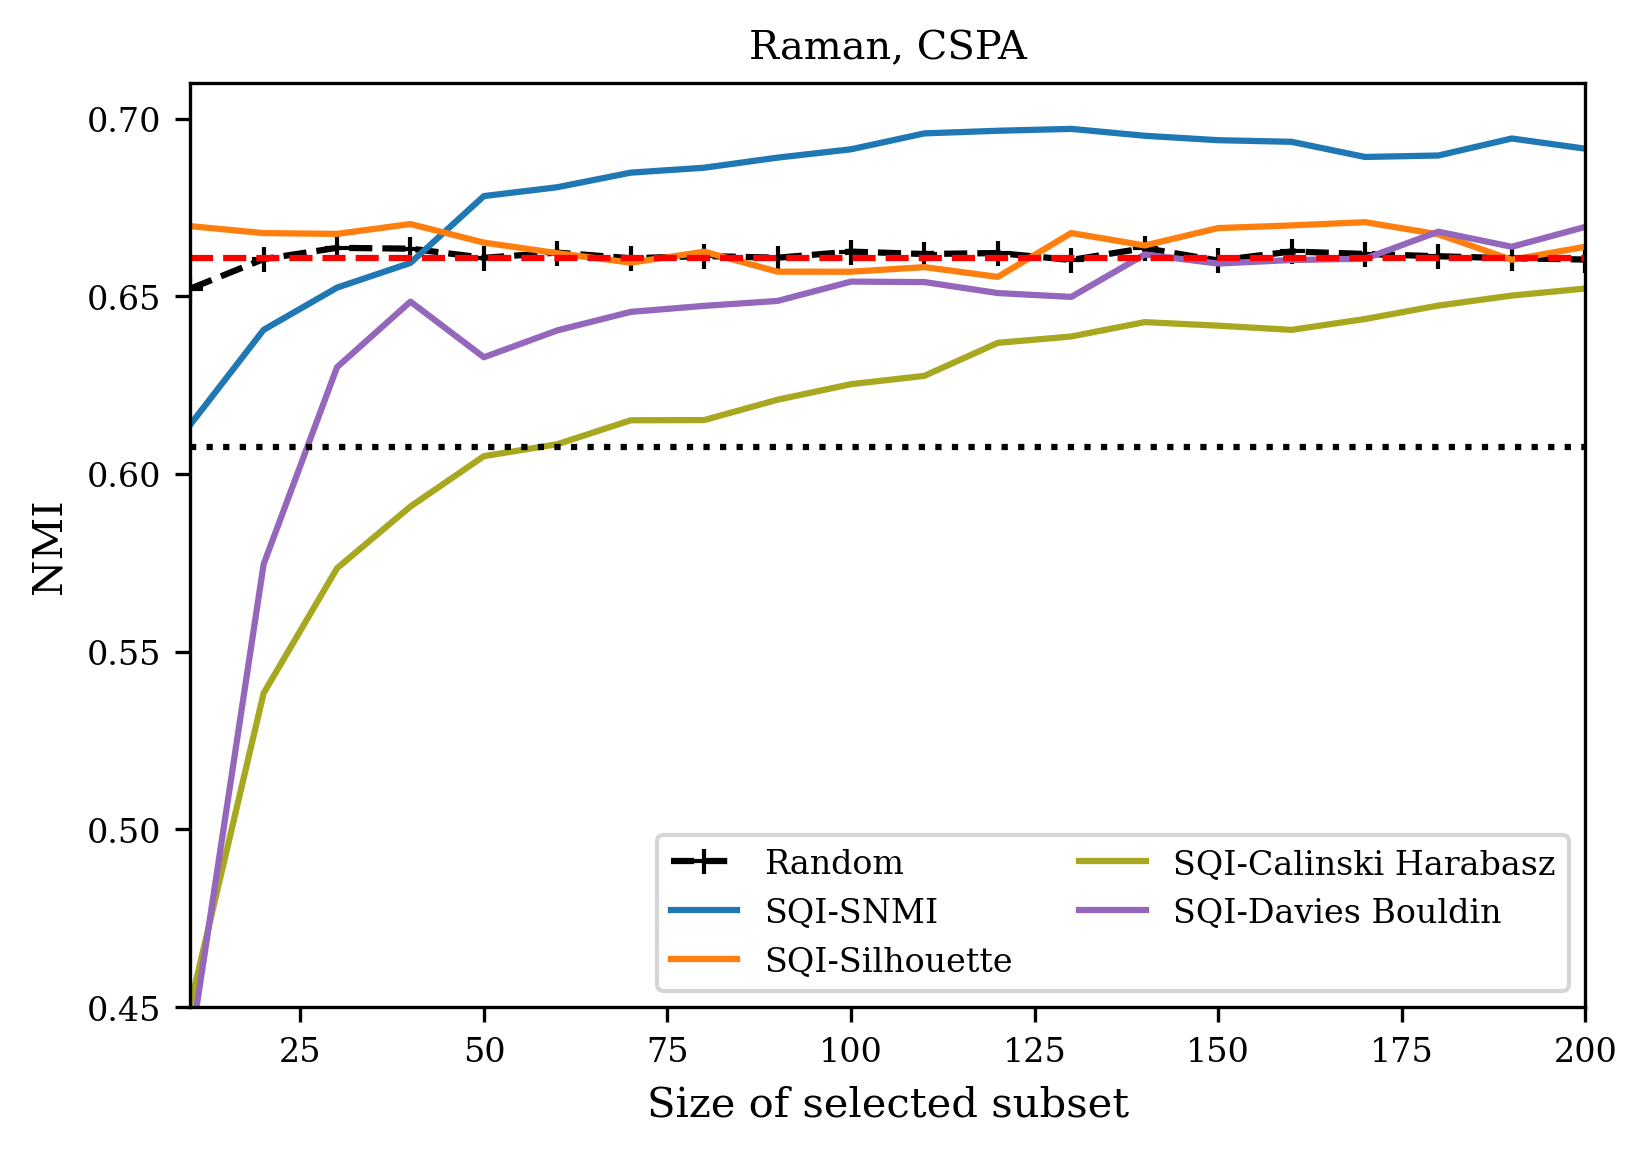

In [31]:
print("SQI performance NMI using CSPA consensus function")
num=range(10,210,10)
fig = plt.figure(figsize=(6,4), dpi=300)
plt.rc('font', family='serif', size = 8)

plt.xlabel('Size of selected subset',fontsize=10)
plt.ylabel('NMI',fontsize=10)
plt.title("Raman, CSPA")
plt.xlim(10,200,10)
plt.ylim(0.45,0.71,0.01)
plt.plot(num,df_final_average.loc["CSPA_Random_NMI"], label = "Random", color="black", linestyle="--",marker="+",ms=6)
plt.plot(num,df_final_average.loc["CSPA_SNMI_NMI"], label = "SQI-SNMI", color="#1f77b4")
plt.plot(num,df_final_average.loc["CSPA_Silhouette_NMI"], label = "SQI-Silhouette", color="#ff7f0e")
plt.plot(num,df_final_average.loc["CSPA_Calinski_Harabasz_NMI"], label = "SQI-Calinski Harabasz", color="#a8a720")
plt.plot(num,df_final_average.loc["CSPA_Davies_Bauldin_NMI"], label = "SQI-Davies Bouldin", color="#9467bd")

plt.axhline(y=NMI_CSPA_EN, color="r", linestyle="--")
plt.axhline(y=NMI_Average, color="black", linestyle=":")
legend = plt.legend(loc='lower right', shadow=False, fontsize=8,ncol=2)
plt.show()
fig.savefig(output_path+filename+" SQI using CSPA comparison NMI.png", bbox_inches="tight", dpi = 300)

SQI performance NMI using HBGF consensus function


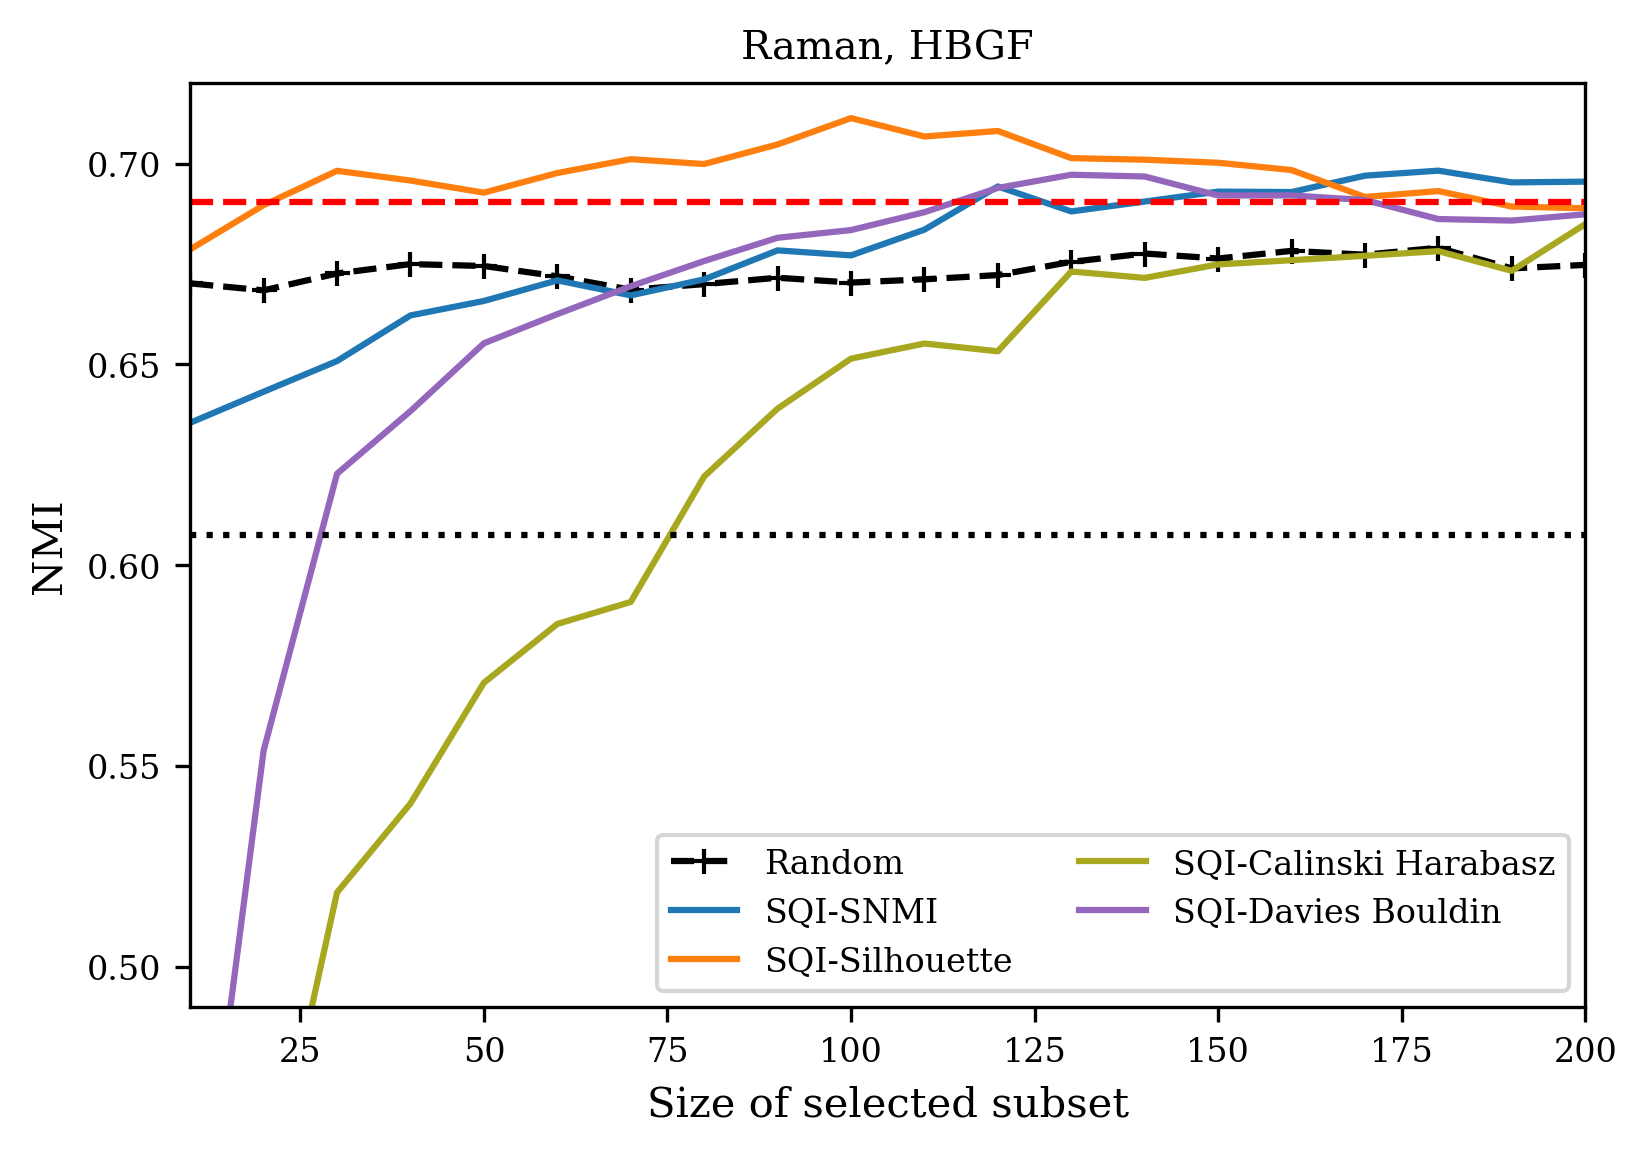

In [33]:
print("SQI performance NMI using HBGF consensus function")
num=range(10,210,10)
fig = plt.figure(figsize=(6,4), dpi=300)
plt.rc('font', family='serif', size = 8)

plt.xlabel('Size of selected subset',fontsize=10)
plt.ylabel('NMI',fontsize=10)
plt.title("Raman, HBGF")
plt.xlim(10,200,10)
plt.ylim(0.49,0.72,0.01)
plt.plot(num,df_final_average.loc["HBGF_Random_NMI"], label = "Random", color="black", linestyle="--",marker="+",ms=6)
plt.plot(num,df_final_average.loc["HBGF_SNMI_NMI"], label = "SQI-SNMI", color="#1f77b4")
plt.plot(num,df_final_average.loc["HBGF_Silhouette_NMI"], label = "SQI-Silhouette", color="#ff7f0e")
plt.plot(num,df_final_average.loc["HBGF_Calinski_Harabasz_NMI"], label = "SQI-Calinski Harabasz", color="#a8a720")
plt.plot(num,df_final_average.loc["HBGF_Davies_Bauldin_NMI"], label = "SQI-Davies Bouldin", color="#9467bd")

plt.axhline(y=NMI_HBGF_EN, color="r", linestyle="--")
plt.axhline(y=NMI_Average, color="black", linestyle=":")
legend = plt.legend(loc='lower right', shadow=False, fontsize=8,ncol=2)
plt.show()
fig.savefig(output_path+filename+" SQI using HBGF comparison NMI.png", bbox_inches="tight", dpi = 300)

#### Dominant ratio
CSPA vs. HBGF

SQI performance Dominant ration using CSPA consensus function


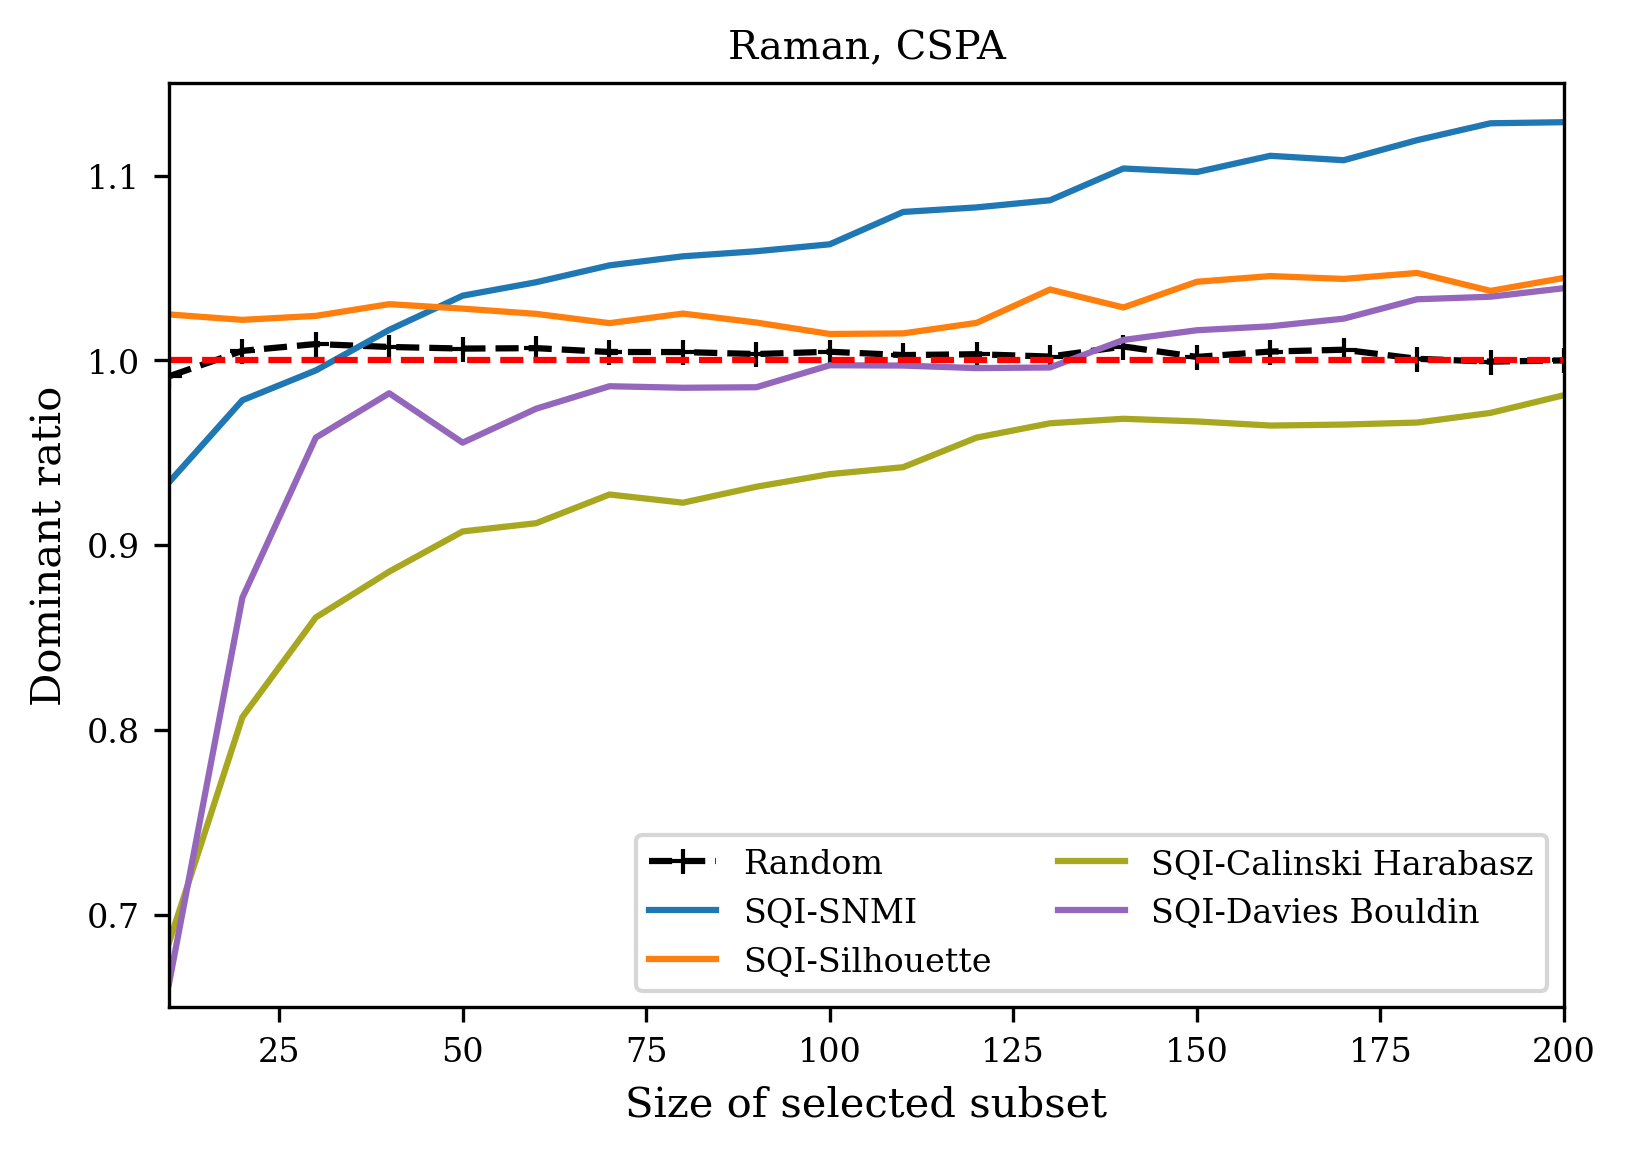

In [34]:
print("SQI performance Dominant ration using CSPA consensus function")
num=range(10,210,10)
fig = plt.figure(figsize=(6,4), dpi=300)
plt.rc('font', family='serif', size = 8)

plt.xlabel('Size of selected subset',fontsize=10)
plt.ylabel('Dominant ratio',fontsize=10)
plt.title("Raman, CSPA")
plt.xlim(10,200,10)
plt.ylim(0.65,1.15,0.01)
plt.plot(num,df_final_average.loc["CSPA_Random_Dominant_ratio"], label = "Random", color="black", linestyle="--",marker="+",ms=6)
plt.plot(num,df_final_average.loc["CSPA_SNMI_Dominant_ratio"], label = "SQI-SNMI", color="#1f77b4")
plt.plot(num,df_final_average.loc["CSPA_Silhouette_Dominant_ratio"], label = "SQI-Silhouette", color="#ff7f0e")
plt.plot(num,df_final_average.loc["CSPA_Calinski_Harabasz_Dominant_ratio"], label = "SQI-Calinski Harabasz", color="#a8a720")
plt.plot(num,df_final_average.loc["CSPA_Davies_Bauldin_Dominant_ratio"], label = "SQI-Davies Bouldin", color="#9467bd")

plt.axhline(y=1.00, color="r", linestyle="--")
legend = plt.legend(loc='lower right', shadow=False, fontsize=8,ncol=2)
plt.show()
fig.savefig(output_path+filename+" SQI using CSPA comparison Dominant ratio.png", bbox_inches="tight", dpi = 300)

SQI performance Dominant ration using HBGF consensus function


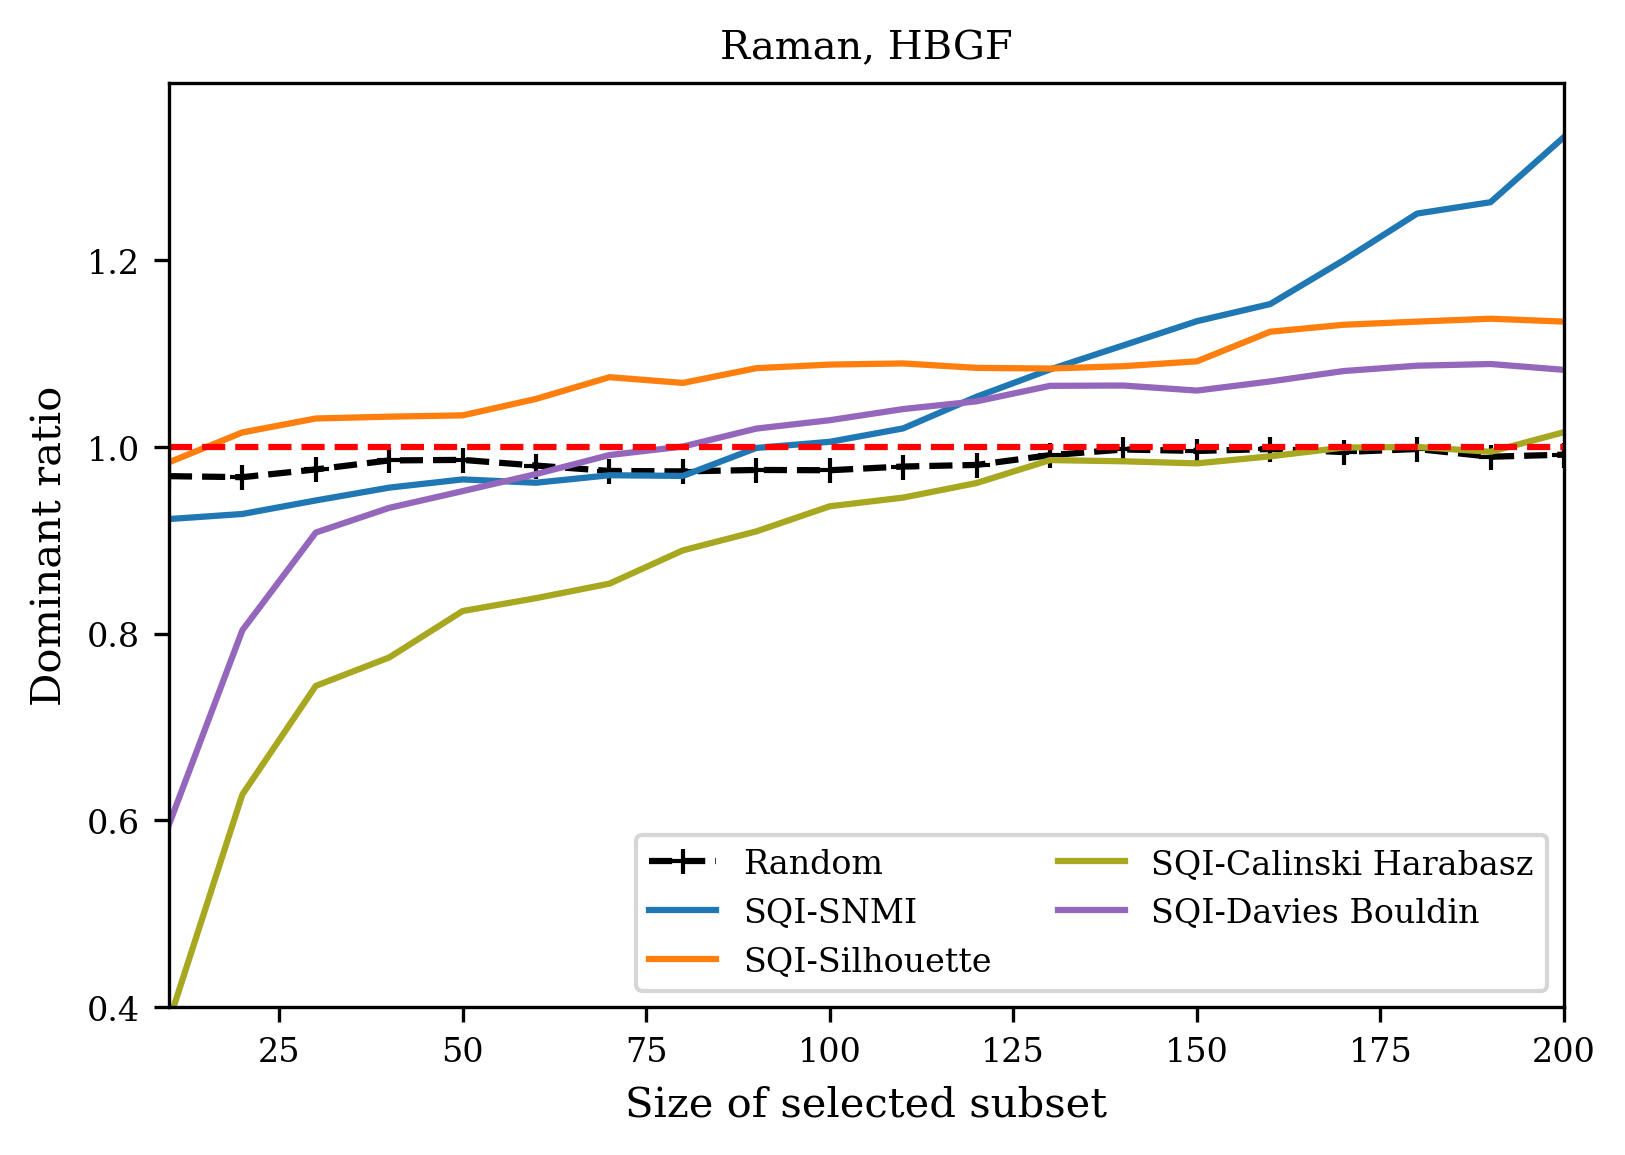

In [37]:
print("SQI performance Dominant ration using HBGF consensus function")
num=range(10,210,10)
fig = plt.figure(figsize=(6,4), dpi=300)
plt.rc('font', family='serif', size = 8)

plt.xlabel('Size of selected subset',fontsize=10)
plt.ylabel('Dominant ratio',fontsize=10)
plt.title("Raman, HBGF")
plt.xlim(10,200,10)
plt.ylim(0.40,1.39,0.01)
plt.plot(num,df_final_average.loc["HBGF_Random_Dominant_ratio"], label = "Random", color="black", linestyle="--",marker="+",ms=6)
plt.plot(num,df_final_average.loc["HBGF_SNMI_Dominant_ratio"], label = "SQI-SNMI", color="#1f77b4")
plt.plot(num,df_final_average.loc["HBGF_Silhouette_Dominant_ratio"], label = "SQI-Silhouette", color="#ff7f0e")
plt.plot(num,df_final_average.loc["HBGF_Calinski_Harabasz_Dominant_ratio"], label = "SQI-Calinski Harabasz", color="#a8a720")
plt.plot(num,df_final_average.loc["HBGF_Davies_Bauldin_Dominant_ratio"], label = "SQI-Davies Bouldin", color="#9467bd")

plt.axhline(y=1.00, color="r", linestyle="--")
legend = plt.legend(loc='lower right', shadow=False, fontsize=8,ncol=2)
plt.show()
fig.savefig(output_path+filename+" SQI using HBGF comparison Dominant ratio.png", bbox_inches="tight", dpi = 300)

### Paired T-test

In [3]:
from scipy import stats

In [4]:
def get_T_test_data(n):
    df = pd.read_csv(dataset_path+filename+".csv")
    Y=df.Class
    
    NMI_CSPA_EN = []
    NMI_HBGF_EN = []
    runs = []
    for i in range(n):
        print("run_"+str(i+1))
        
        result_i = pd.read_csv(output_path+filename+" BC library run_"+str(i+1)+".csv", index_col="Unnamed: 0")
        Y_CSPA_EN = result_i.loc["CSPA_EN"]
        NMI_CSPA_EN.append(normalized_mutual_info_score(Y,Y_CSPA_EN)) 
        Y_HBGF_EN = result_i.loc["HBGF_EN"]
        NMI_HBGF_EN.append(normalized_mutual_info_score(Y,Y_HBGF_EN))

        run_i = pd.read_csv(output_path+filename+" SQI comparison run_"+str(i+1)+".csv",index_col="Unnamed: 0")
        runs.append(run_i)
    
    print("Total of ", len(runs), "iterations to avearge")
    
    df_concat=pd.concat(runs)
    
    return df_concat, NMI_CSPA_EN, NMI_HBGF_EN

In [12]:
filename="0.971 scaled DFT 6-311++G(d,p) Raman dataset"
row_idx = ['CSPA_SNMI_NMI', 'CSPA_Silhouette_NMI','CSPA_Random_NMI','HBGF_SNMI_NMI','HBGF_Silhouette_NMI','HBGF_Random_NMI']
column_idx = [2, 5,8,11,14,17]
df_Test_Data, NMI_CSPA, NMI_HBGF = get_T_test_data(20)

run_1
run_2
run_3
run_4
run_5
run_6
run_7
run_8
run_9
run_10
run_11
run_12
run_13
run_14
run_15
run_16
run_17
run_18
run_19
run_20
Total of  20 iterations to avearge


In [13]:
print(np.mean(NMI_CSPA), np.std(NMI_CSPA))
shapiro_test = stats.shapiro(NMI_CSPA)
if shapiro_test.pvalue >=0.05:
    print("YES, data is normally distributed")
else:
    print("No, data is non-normally distributed, t test is not appopriate")
print(np.mean(NMI_HBGF), np.std(NMI_HBGF))
shapiro_test = stats.shapiro(NMI_HBGF)
if shapiro_test.pvalue >=0.05:
    print("YES, data is normally distributed")
else:
    print("No, data is non-normally distributed, t test is not appopriate")

0.6607164486962144 0.011841835514762462
YES, data is normally distributed
0.6904820544427916 0.016005759647064074
YES, data is normally distributed


In [14]:
for i in range(0,3):
    print(row_idx[i])
    df_tmp_1 = df_Test_Data.loc[row_idx[i]]
    df_tmp_2 = df_tmp_1.iloc[:,column_idx]
    print(df_tmp_2.describe())
    
    for j in range(6):
        shapiro_test = stats.shapiro(df_tmp_2.iloc[:,j])
        if shapiro_test.pvalue >=0.05:
            print("YES, data is normally distributed")
        else:
            print("No, data is non-normally distributed, t test is not appopriate")
            
        t_test = stats.ttest_rel(NMI_CSPA,df_tmp_2.iloc[:,j])
        print(t_test.pvalue)
        if t_test.pvalue >= 0.05:
            print("p-value is not less than 0.05, fail to reject the null hypothesis, not statistically significant")
        else:
            print("YES!")
            print("p-value is less than 0.05, reject the null hypothesis, data is statistically significant")

CSPA_SNMI_NMI
              30         60         90        120        150        180
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000
mean    0.652472   0.680721   0.689053   0.696608   0.693953   0.689645
std     0.018918   0.011820   0.013357   0.010477   0.010071   0.009952
min     0.622299   0.648422   0.666248   0.671212   0.678291   0.667229
25%     0.637104   0.674702   0.679482   0.694224   0.687382   0.683016
50%     0.648745   0.681850   0.688910   0.698385   0.695096   0.691902
75%     0.661267   0.687196   0.699456   0.703247   0.700911   0.696365
max     0.688836   0.701873   0.708837   0.712728   0.713677   0.705615
YES, data is normally distributed
0.11743606488036845
p-value is not less than 0.05, fail to reject the null hypothesis, not statistically significant
YES, data is normally distributed
3.9423914145002146e-05
YES!
p-value is less than 0.05, reject the null hypothesis, data is statistically significant
YES, data is normally distributed
6.

In [15]:
for i in range(3,6):
    print(row_idx[i])
    df_tmp_1 = df_Test_Data.loc[row_idx[i]]
    df_tmp_2 = df_tmp_1.iloc[:,column_idx]
    print(df_tmp_2.describe())
    
    for j in range(6):
        shapiro_test = stats.shapiro(df_tmp_2.iloc[:,j])
        if shapiro_test.pvalue >=0.05:
            print("YES, data is normally distributed")
        else:
            print("No, data is non-normally distributed, t test is not appopriate")
        t_test = stats.ttest_rel(NMI_HBGF,df_tmp_2.iloc[:,j])
        print(t_test.pvalue)
        if t_test.pvalue >= 0.05:
            print("p-value is not less than 0.05, fail to reject the null hypothesis, not statistically significant")
        else:
            print("YES!")
            print("p-value is less than 0.05, reject the null hypothesis, data is statistically significant")

HBGF_SNMI_NMI
              30         60         90        120        150        180
count  20.000000  20.000000  20.000000  20.000000  20.000000  20.000000
mean    0.650831   0.670912   0.678378   0.694292   0.693007   0.698224
std     0.012732   0.010207   0.012083   0.020000   0.010353   0.010081
min     0.614786   0.651127   0.663504   0.669075   0.671948   0.678097
25%     0.646023   0.667300   0.670916   0.678685   0.686320   0.693224
50%     0.654011   0.671554   0.674670   0.690538   0.691623   0.696639
75%     0.657627   0.673451   0.682217   0.700509   0.699699   0.705512
max     0.666722   0.692779   0.712340   0.736124   0.713051   0.720310
No, data is non-normally distributed, t test is not appopriate
1.4608596971658823e-07
YES!
p-value is less than 0.05, reject the null hypothesis, data is statistically significant
YES, data is normally distributed
0.0006281560586446535
YES!
p-value is less than 0.05, reject the null hypothesis, data is statistically significant
No, data